In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.__version__

'1.26.4'

# Getting the data ready

In [295]:
### Importing the data

import os
data_dir = os.getcwd() + "/data"
train_dir = data_dir + "/train.csv"
test_dir = data_dir + "/test.csv"

train_size, test_size = os.path.getsize(train_dir), os.path.getsize(test_dir)
train_size, test_size = train_size / (1024*1024), test_size / (1024*1024)
train_size, test_size = round(train_size, 2), round(test_size, 2)
print(f"Train size: {train_size} MB | Test size: {test_size} MB")

Train size: 104.56 MB | Test size: 17.46 MB


In [3]:
### Creating the dataframes

train_df = pd.read_csv(train_dir)
test_df = pd.read_csv(test_dir)
len(train_df), len(test_df)

(60000, 10000)

In [4]:
### Get the split size of the data (%)

print(f"Split size:")
print(f"Train data: {round(len(train_df) / (len(train_df) + len(test_df)) * 100, 2)}%")
print(f"Test data: {round(len(test_df) / (len(train_df) + len(test_df)) * 100, 2)}%")

Split size:
Train data: 85.71%
Test data: 14.29%


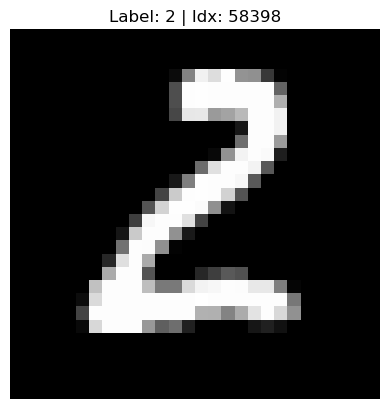

In [5]:
### Sample some random images from the data

import random
#random.seed(42)
idx = random.randint(0, len(train_df))
img, label = train_df.drop(["label"], axis = 1).iloc[idx].to_numpy(), train_df["label"].iloc[idx]
img = img.reshape(28, 28)

plt.imshow(img, cmap="grey")
plt.title(f"Label: {label} | Idx: {idx}")
plt.axis(False);

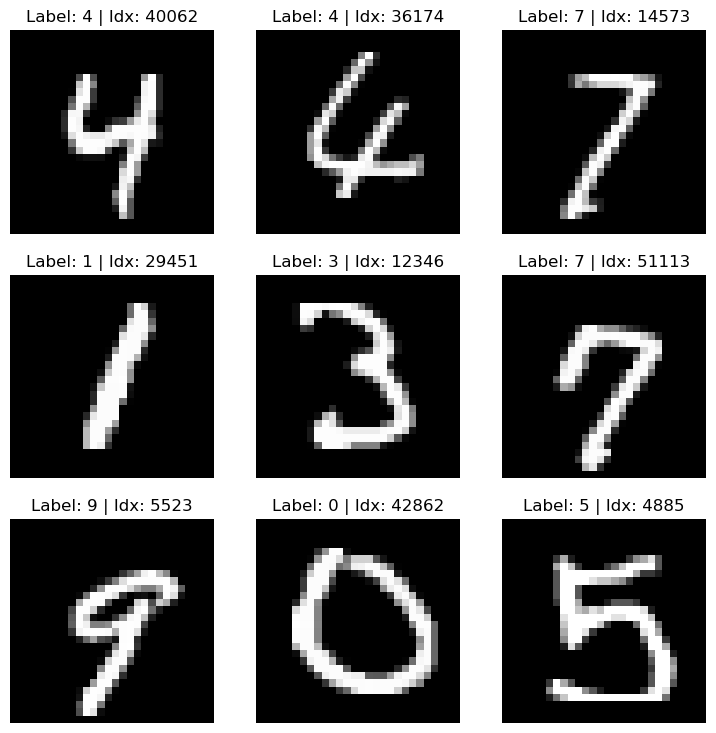

In [6]:
### Plotting 9 images with their labels

idxes = random.sample(range(0, len(train_df)), k = 9)
fig, axes = plt.subplots(figsize = (9, 9), nrows = 3, ncols = 3)
axes = axes.flatten()
for idx, ax in zip(idxes, axes):
    img, label = train_df.drop(["label"], axis = 1).iloc[idx].to_numpy(), train_df["label"].iloc[idx]
    img = img.reshape(28, 28)
    
    ax.imshow(img, cmap="grey")
    ax.set_title(f"Label: {label} | Idx: {idx}")
    ax.axis(False);

In [324]:
### Split the df's into features and labels

X_train, y_train = train_df.drop(["label"], axis=1), train_df["label"]
X_test, y_test = test_df.drop(["label"], axis=1), test_df["label"]
print(f"Data split into features and labels: {len(X_train), len(y_train), len(X_test), len(y_test)}")

### Normalize the data

print(f"\nOld pixel range: {min(X_train.iloc[0]), max(X_train.iloc[0])}")
X_train = X_train/255
X_test = X_test / 255
print(f"New pixel range: {min(X_train.iloc[0]), max(X_train.iloc[0])}")

### Transpose the feature matrix

"""print(f"\nShape before transpose: {X_train.shape}, {X_test.shape}")
X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T
print(f"Shape after transpose: {X_train.shape}, {X_test.shape}")"""

Data split into features and labels: (60000, 60000, 10000, 10000)

Old pixel range: (0, 255)
New pixel range: (0.0, 1.0)


'print(f"\nShape before transpose: {X_train.shape}, {X_test.shape}")\nX_train = X_train.T\nX_test = X_test.T\ny_train = y_train.T\ny_test = y_test.T\nprint(f"Shape after transpose: {X_train.shape}, {X_test.shape}")'

In [325]:
### Convert the data into np-arrays
X_train, y_train = X_train.to_numpy(), y_train.to_numpy()
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()

In [330]:
X_train[:32, :].shape, y_train[5]

((32, 784), 2)

# Modeling

## Classes

In [414]:
### Linear layer for the model
class Linear():
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 bias: bool = True,
                 seed: int = None):
        ### Create the weights and biases
        np.random.seed(seed)
        self.weights = np.random.rand(out_features, in_features) * 0.01
        self.bias = np.zeros(out_features) if bias else None
        ### Track the grad's of the weights and the biases
        self.weights_grad = np.zeros_like(self.weights)
        self.bias_grad = np.zeros_like(self.bias) if self.bias is not None else None
        
    def forward(self, x):
        """
        Performs a forward pass on the linear layer,
        and returns the output of the layer.
        """
        #print(f"Linear layer input shape: {x.shape}")
        self.input = x
        x = x @ self.weights.T
        #print(f"Linear layer output shape: {x.shape}")
        if self.bias is not None:
            x = x + self.bias
        return x

    def backward(self,
                 grad_output):
        """
        Performs the backward pass for the linear layer

        Args:
            grad_output - grad of the loss with respect to this layer's output
        """
        ### Error handling
        if grad_output is None:
            raise ValueError("grad_output cannot be None")
        ### dL/dW = (dL/dY).T @ X
        #self.weights_grad = grad_output[:, None] @ self.input[None, :]
        self.weights_grad = grad_output.T @ self.input
        ### dL/db = (dL/dY).sum
        if self.bias is not None:
            self.bias_grad = grad_output
        ### dL/dX = dL/dY @ W
        grad_input = grad_output @ self.weights
        return grad_input
        
    def parameters(self):
        num_weights = self.weights.size
        num_bias = self.bias.size
        return num_weights + num_bias

In [399]:
### Creating a few activation functions
class ReLU():
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        grad_input = grad_output * (self.input > 0)
        return grad_input
    
    def parameters(self):
        return None

class Softmax():
    def forward(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))  # Numerical stability trick
        self.output = exps / np.sum(exps, axis=1, keepdims=True)  # Ensure sum is over correct axis
        return self.output

    def backward(self, grad_output):
        return grad_output  # Softmax doesn't change gradient during backpropagation

    def parameters(self):
        return None

In [297]:
class Sequential():
    def __init__(self,
                 layers: list,
                 lr: float = 1e-3,
                 name: str = "Sequential model"):
        """
        Initializes the layers of the model
        """
        self.layers = layers
        self.lr = lr
        self.name = name
        
    def forward(self, x):
        """
        Performs forward propagation and returns the output of the model
        """
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self,
                 loss_grad):
        """
        Performs the backward pass on the model's parameters,
        and updates the weights of the model
        """
        ### Perform the backward pass
        grad = loss_grad
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def update_params(self):
        ### Update weights and biases using gradient descent
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.weights = layer.weights - (self.lr * layer.weights_grad)
                if layer.bias is not None:
                    layer.bias = layer.bias - (self.lr * layer.bias_grad)
            
        
    def summary(self):
        """
        Prints the model's layers and their parameters
        """
        print(f"Model: {self.name}\n")
        print(f"Layer name\t| Num params")
        print(f"---------------\t| ---------")
        sum = 0
        for layer in self.layers:
            print(f"{layer.__class__.__name__}\t\t| {layer.parameters()}")
            sum += layer.parameters() if layer.parameters() is not None else 0
        print(f"Total params: {sum}")

In [358]:
### Loss functions
class CrossEntropyLoss():
    def __init__(self,
                 batch_size: int = None):
        self.y_pred = None
        self.y_true = None
        self.batch_size = batch_size
        
    def __call__(self, y_pred, y_true):
        """
        Calculates the loss given the True and Predicted values,
        and returns it.
        """
        self.y_pred = y_pred
        self.y_true = y_true
        ### Clip predictions to prevent log(0)
        y_pred = np.clip(y_pred, 1e-10, 1.0-1e-10)
        ### Calculate cross-entropy loss
        loss = -np.sum(y_true * np.log(y_pred))
        if self.batch_size is not None:
             loss /= self.batch_size
        return loss

    def backward(self):
        """
        Calculates the loss with respect to the True and Predicted values,
        and returns it.
        """
        grad = (self.y_pred - self.y_true)
        if self.batch_size is not None:
            grad /= self.batch_size
        return grad
    
    def parameters(self):
        return None

class SparseCrossEntropyLoss():
    def __init__(self, batch_size: int = None):
        self.y_pred = None
        self.y_true = None
        self.batch_size = batch_size
        
    def __call__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
        y_pred = np.clip(y_pred, 1e-10, 1.0 - 1e-10)
        
        # Calculate sparse cross-entropy loss
        loss = -np.log(y_pred[np.arange(len(y_true)), y_true])
        
        if self.batch_size is not None:
            loss = np.sum(loss) / self.batch_size
        else:
            loss = np.sum(loss) / len(y_true)
        
        return loss

    def backward(self):
        grad = self.y_pred.copy()
        grad[np.arange(len(self.y_true)), self.y_true] -= 1
        
        if self.batch_size is not None:
            grad /= self.batch_size
        
        return grad
    
    def parameters(self):
        return None

In [243]:
Sequential([
    Linear(in_features = 28*28, out_features = 3),
    Linear(in_features = 3, out_features = 3),
    ReLU(),
    Softmax()
]).forward(np.random.rand(28*28))

array([0.33597436, 0.33631166, 0.32771398])

## Model 1

### Model testing

In [290]:
model_1 = Sequential([
    Linear(in_features = 28*28, out_features = 10),
    ReLU(),
    Linear(in_features = 10, out_features = 10),
    Softmax(),
])
model_1.summary()

Layer name	| Num params
---------------	| ---------
Linear		| 7850
ReLU		| None
Linear		| 110
Softmax		| None
Total params: 7960


In [291]:
### Sample data
y_true = np.random.randint(0, 2, size = 10)
x = np.random.rand(28**2)

In [292]:
# Forward propagation
y1 = model_1.forward(x)

# Back propagation
loss_fn = CrossEntropyLoss()
loss = loss_fn(y1, y_true)
loss_grad = loss_fn.backward()
print(f"Loss = {loss}")
model_1.backward(loss_grad)
model_1.update_params()

# Forward propagation to verify backward propagation
y2 = model_1.forward(x)

print()
print(y1)
print(y2)
print()
loss = loss_fn(y2, y_true)
print(f"Loss = {loss}")
print()
print(y_true)

Loss = 9.206893010579723

[0.10036342 0.10331771 0.09811664 0.09761191 0.10175439 0.09912883
 0.10364958 0.09728067 0.10114988 0.09762697]
[0.09874564 0.10580008 0.10048175 0.09604404 0.10420112 0.09753658
 0.10197623 0.09963013 0.09952211 0.09606233]

Loss = 9.11170630843505

[0 1 1 0 1 0 0 1 0 0]


In [293]:
for epoch in range(10):
    y = model_1.forward(x)
    loss = loss_fn(y_pred = y, y_true = y_true)
    loss_grad = loss_fn.backward()
    print(f"Epoch: {epoch+1} | Loss: {loss}")
    model_1.backward(loss_grad)
    model_1.update_params()

Epoch: 1 | Loss: 9.11170630843505
Epoch: 2 | Loss: 9.017743149039026
Epoch: 3 | Loss: 8.924728389027747
Epoch: 4 | Loss: 8.832411143752395
Epoch: 5 | Loss: 8.740564241141186
Epoch: 6 | Loss: 8.648983918739372
Epoch: 7 | Loss: 8.557489745481657
Epoch: 8 | Loss: 8.465924747785765
Epoch: 9 | Loss: 8.374155716877393
Epoch: 10 | Loss: 8.28207367081823


### Creating, training, inferencing

In [436]:
### Creating the model
model_1 = Sequential(
    [Linear(in_features = 28**2, out_features = 10),
     ReLU(),
     Linear(in_features = 10, out_features = 10),
     Softmax()],
    lr = 1e-2,
    name = "model_1"
)

model_1.summary()

Model: model_1

Layer name	| Num params
---------------	| ---------
Linear		| 7850
ReLU		| None
Linear		| 110
Softmax		| None
Total params: 7960


In [437]:
# Adjust the training loop to ensure correct shapes
epochs = 3
batch_size = 1
loss_fn = SparseCrossEntropyLoss(batch_size=batch_size)

for epoch in range(epochs):
    for _ in range(len(X_train)-len(X_train)//2):
        X_batch = X_train[:batch_size, :]
        y_batch = y_train[:batch_size].flatten()
    
        y_pred = model_1.forward(X_batch)
        #print(y_pred.shape)
        #print(y_batch.shape)
        
        loss = loss_fn(y_pred=y_pred, y_true=y_batch)
        loss_grad = loss_fn.backward()
        #print(loss_grad.shape)
    
        model_1.backward(loss_grad)
        model_1.update_params()
    if (epoch+1) % 1 == 0:
        print(f"Epoch: {epoch + 1} | Loss: {loss:.4f}")

Epoch: 1 | Loss: 0.0000
Epoch: 2 | Loss: 0.0000
Epoch: 3 | Loss: 0.0000


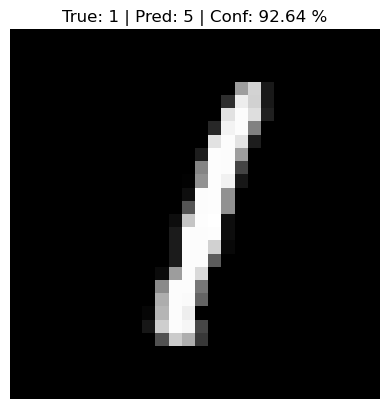

In [463]:
### Making predictions

idx = random.randint(0, len(X_train)-1)
img, label = X_train[idx, :], y_train[idx]
img = img.reshape(1, -1)
pred = model_1.forward(img)
#print(pred.shape)

### Plot the image and prediction

img = img.reshape((28, 28))
plt.imshow(img,
           cmap = "grey")
plt.axis(False)
plt.title(f"True: {label} | Pred: {np.argmax(pred)} | Conf: {pred[0][np.argmax(pred)]*100:.2f} %");